In [178]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from collections import Counter
# import warnings
# warnings.filterwarnings("error")

In [179]:
read=pd.read_csv("train_ps0mmDv_9yr6iGN/train/train_submissions.csv")
problem=pd.read_csv("train_ps0mmDv_9yr6iGN/train/problem_data.csv")
user=pd.read_csv("train_ps0mmDv_9yr6iGN/train/user_data.csv")
test=pd.read_csv("test_submissions_NeDLEvX.csv")

In [180]:
test1=test.merge(problem,on='problem_id').merge(user,on='user_id')

In [181]:
train=read.merge(user,on='user_id').merge(problem,on='problem_id')

In [182]:
train.isna().any()

user_id                      False
problem_id                   False
attempts_range               False
submission_count             False
problem_solved               False
contribution                 False
country                       True
follower_count               False
last_online_time_seconds     False
max_rating                   False
rating                       False
rank                         False
registration_time_seconds    False
level_type                    True
points                        True
tags                          True
dtype: bool

###### Preprocessing & Exploratory Analysis

In [183]:
train['level_type'].unique()

array(['B', 'A', 'C', 'D', 'E', 'G', 'I', 'F', 'H', nan, 'J', 'K', 'L',
       'M', 'N'], dtype=object)

In [184]:
train['level_type'] = train['level_type'].fillna(train['level_type'].mode()[0])
test1['level_type'] = test1['level_type'].fillna(test1['level_type'].mode()[0])

In [185]:
train['level_type'].unique()

array(['B', 'A', 'C', 'D', 'E', 'G', 'I', 'F', 'H', 'J', 'K', 'L', 'M',
       'N'], dtype=object)

In [186]:
LevelType=train.groupby('level_type')['user_id'].nunique().reset_index()

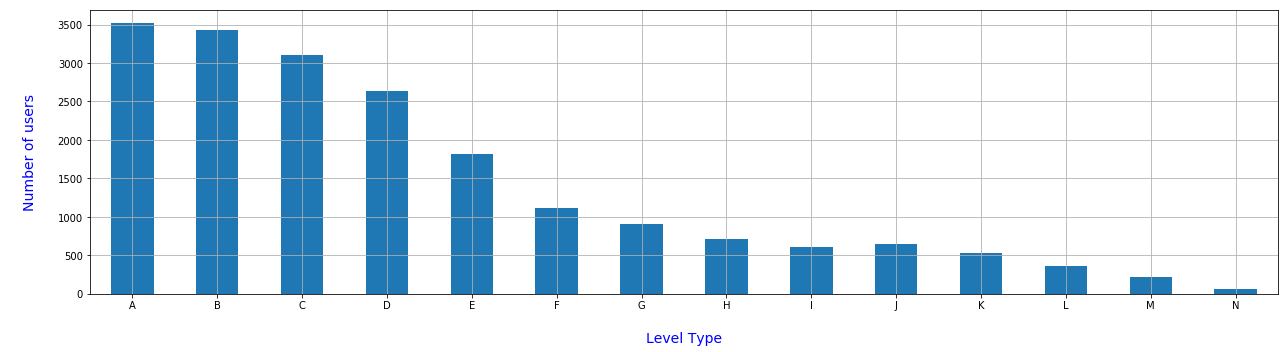

In [187]:
LevelType.set_index('level_type')['user_id'].plot.bar(figsize=(18,5),grid=True,rot=0)
plt.xlabel("\nLevel Type",fontsize=14,color='blue')
plt.ylabel("\nNumber of users\n",fontsize=14,color='blue')
plt.tight_layout()

In [188]:
le = LabelEncoder()
train['level_type'] = le.fit_transform(train['level_type'])
test1['level_type'] = le.transform(test1['level_type'])

In [189]:
train['rank'].unique()

array(['beginner', 'intermediate', 'advanced', 'expert'], dtype=object)

In [190]:
Rank=train.groupby('rank')['user_id'].nunique().reset_index()

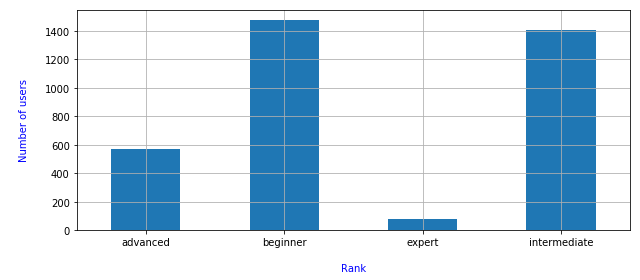

In [191]:
Rank.set_index('rank')['user_id'].plot.bar(figsize=(9,4),grid=True,rot=0)
plt.xlabel("\nRank",fontsize=10,color='blue')
plt.ylabel("\nNumber of users\n",fontsize=10,color='blue')
plt.tight_layout()

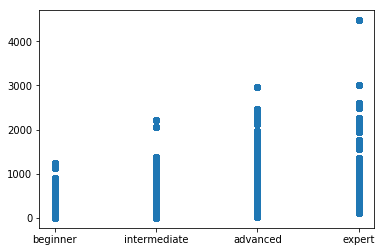

In [192]:
plt.scatter(x=train['rank'],y=train['problem_solved'])

In [193]:
le = LabelEncoder()
train['rank'] = le.fit_transform(train['rank'])
test1['rank'] = le.transform(test1['rank'])

In [194]:
country=train.groupby('country')['user_id'].nunique().reset_index()

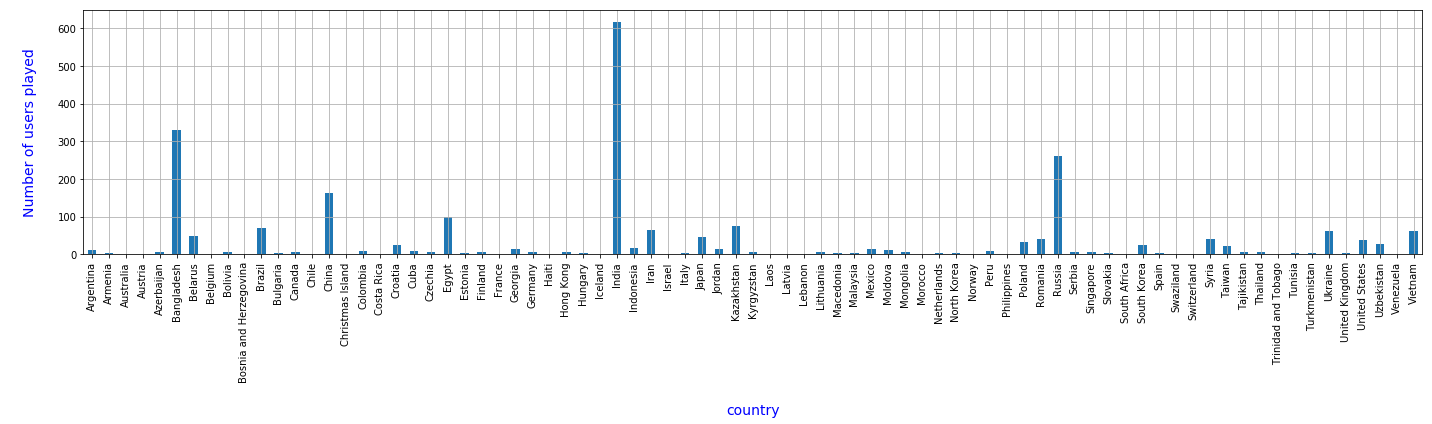

In [195]:
country.set_index('country')['user_id'].plot.bar(figsize=(20,6),grid=True,rot=90)
plt.xlabel("\ncountry",fontsize=14,color='blue')
plt.ylabel("\nNumber of users played\n",fontsize=14,color='blue')
plt.tight_layout()

In [196]:
train['country'] = train['country'].fillna(train['country'].mode()[0])
test1['country'] = test1['country'].fillna(test1['country'].mode()[0])
train['country'] = le.fit_transform(train['country'])
test1['country'] = le.fit_transform(test1['country'])

In [197]:
train['user_id']=train['user_id'].str.replace('user_','')
test1['user_id'] = test1['user_id'].str.replace('user_','')
train['problem_id'] = train['problem_id'].str.replace('prob_','')
test1['problem_id'] = test1['problem_id'].str.replace('prob_','')

In [198]:
train['diffonlinesec']=train['last_online_time_seconds']-train['registration_time_seconds']
test1['diffonlinesec']=test1['last_online_time_seconds']-test1['registration_time_seconds']
#####################################
train['days']=train['diffonlinesec']//(24*3600)
test1['days']=test1['diffonlinesec']//(24*3600)

In [199]:
train['tags']=train['tags'].fillna('-999')
test1['tags']=test1['tags'].fillna('-999')

In [200]:
le = LabelEncoder()
train['tags'] = le.fit_transform(train['tags'])
test1['tags'] = le.fit_transform(test1['tags'])

In [201]:
train['sumfollower']=train.groupby('user_id')['follower_count'].transform('sum')
train['AvgProblemsolved']=train.groupby('user_id')['problem_solved'].transform('mean')
train['SumProblemsolved']=train.groupby('user_id')['problem_solved'].transform('sum')
##########################
test1['sumfollower']=test1.groupby('user_id')['follower_count'].transform('sum')
test1['AvgProblemsolved']=test1.groupby('user_id')['problem_solved'].transform('mean')
test1['SumProblemsolved']=test1.groupby('user_id')['problem_solved'].transform('sum')

In [202]:
train['sumcontribution']=train.groupby('user_id')['contribution'].transform('sum')
#####################
test1['sumcontribution']=test1.groupby('user_id')['contribution'].transform('sum')

In [203]:
# train['user_id'] = le.fit_transform(train['user_id'])
# train['problem_id'] = le.fit_transform(train['problem_id'])
train['user_id'] = train['user_id'].astype('int')
train['problem_id'] = train['problem_id'].astype('int')
#############################
# test1['user_id'] = le.fit_transform(test1['user_id'])
# test1['problem_id'] = le.fit_transform(test1['problem_id'])
test1['user_id'] = test1['user_id'].astype('int')
test1['problem_id'] = test1['problem_id'].astype('int')

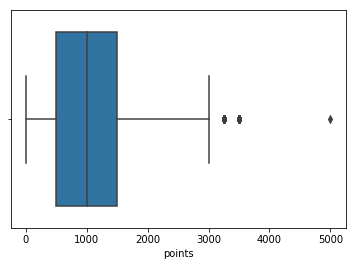

In [204]:
ax = sns.boxplot(x=train['points'])

In [205]:
qt = QuantileTransformer(output_distribution='normal')
train['points']=train['points'].fillna(train['points'].median())
train['npoints'] = qt.fit_transform(train[['points']].values)
#######################
test1['points']=test1['points'].fillna(test1['points'].median())
test1['npoints'] = qt.fit_transform(test1[['points']].values)

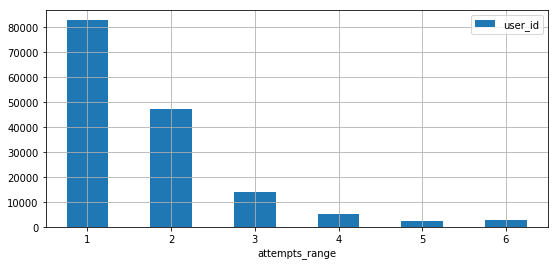

In [206]:
attemptRange=train.groupby('attempts_range').count()['user_id'].reset_index()
attemptRange.set_index('attempts_range').plot.bar(figsize=(9,4),grid=True,rot=0)

In [207]:
train['submission_count_norm']=np.cbrt(train['submission_count'])

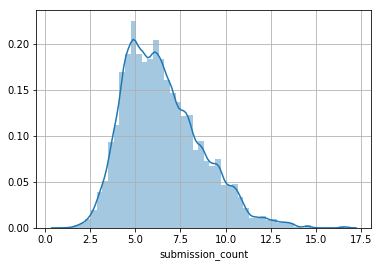

In [208]:
sns.distplot(np.cbrt(train['submission_count']))
plt.grid()

###### Model Training

In [209]:
X1=train.drop(['attempts_range','last_online_time_seconds','registration_time_seconds','rating',
              'points','submission_count_norm','problem_solved',
              'follower_count','contribution','AvgProblemsolved'],axis=1)
Y1=train['attempts_range']

In [210]:
x_train, x_test, y_train, y_test = train_test_split(X1, Y1, test_size=0.3,random_state=123)

In [211]:
Counter(y_train),Counter(y_test)

(Counter({1: 57970, 2: 33101, 3: 9846, 4: 3903, 6: 2105, 5: 1781}),
 Counter({2: 14219, 1: 24834, 5: 715, 3: 4297, 4: 1596, 6: 928}))

In [212]:
train.columns

Index(['user_id', 'problem_id', 'attempts_range', 'submission_count',
       'problem_solved', 'contribution', 'country', 'follower_count',
       'last_online_time_seconds', 'max_rating', 'rating', 'rank',
       'registration_time_seconds', 'level_type', 'points', 'tags',
       'diffonlinesec', 'days', 'sumfollower', 'AvgProblemsolved',
       'SumProblemsolved', 'sumcontribution', 'npoints',
       'submission_count_norm'],
      dtype='object')

In [215]:
from xgboost import XGBClassifier
xgb = XGBClassifier(max_depth=13 ,min_child_weight = 5,gamma = 0,
                   subsample=0.8,colsample_bytree = 0.8,reg_alpha=0.05,learning_rate =0.1,
                   n_estimators=1000,objective='multi:softmax',metrics=['mlogloss','merror'],
                                num_classes=6) 
eval_set = [(x_test, y_test)]
xgb.fit(x_train, y_train,early_stopping_rounds=10,eval_set=eval_set,verbose=True) #fit model on train set
xgb_pred_y_test = xgb.predict(x_test)             # predict on test set
xgb_pred_y_train = xgb.predict(x_train)           # predict on train set

[0]	validation_0-merror:0.468995
Will train until validation_0-merror hasn't improved in 10 rounds.
[1]	validation_0-merror:0.462963
[2]	validation_0-merror:0.460066
[3]	validation_0-merror:0.457855
[4]	validation_0-merror:0.456009
[5]	validation_0-merror:0.456546
[6]	validation_0-merror:0.456696
[7]	validation_0-merror:0.456202
[8]	validation_0-merror:0.455472
[9]	validation_0-merror:0.455344
[10]	validation_0-merror:0.4547
[11]	validation_0-merror:0.455022
[12]	validation_0-merror:0.455494
[13]	validation_0-merror:0.455794
[14]	validation_0-merror:0.455902
[15]	validation_0-merror:0.456095
[16]	validation_0-merror:0.45603
[17]	validation_0-merror:0.455687
[18]	validation_0-merror:0.455365
[19]	validation_0-merror:0.455022
[20]	validation_0-merror:0.454635
[21]	validation_0-merror:0.454013
[22]	validation_0-merror:0.453905
[23]	validation_0-merror:0.45382
[24]	validation_0-merror:0.452832
[25]	validation_0-merror:0.452875
[26]	validation_0-merror:0.45294
[27]	validation_0-merror:0.453

In [216]:
set(xgb_pred_y_test),set(xgb_pred_y_train)

({1, 2, 3, 4, 6}, {1, 2, 3, 4, 5, 6})

##### Feature Importance

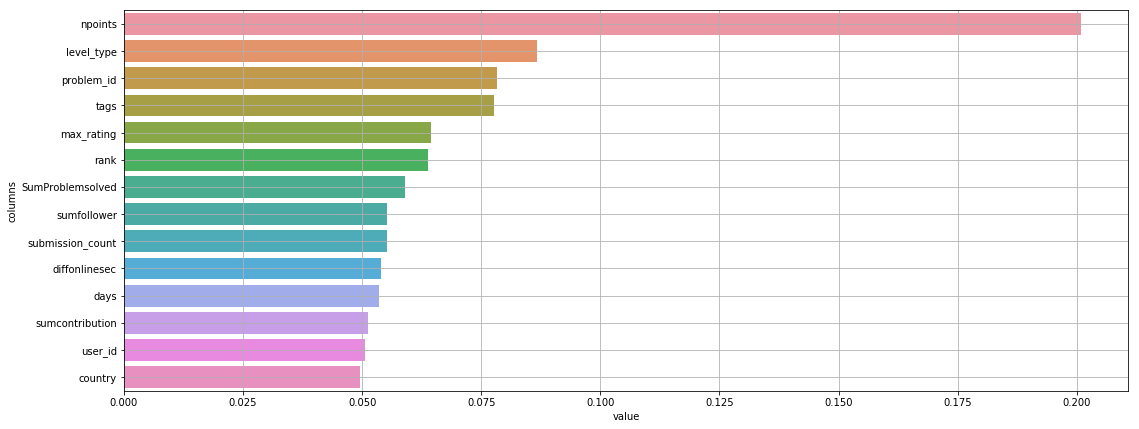

In [218]:
df1=pd.DataFrame()
df1['value']=xgb.feature_importances_
df1['columns']=x_train.columns
df1.sort_values(by='value', ascending=False, inplace=True)

plt.figure(figsize=(18,7))
ax = sns.barplot(y="columns", x="value", data=df1)
plt.grid()

In [217]:
f1_score(xgb_pred_y_train,y_train,average='weighted'),f1_score(xgb_pred_y_test,y_test,average='weighted')

(0.7219614420642696, 0.6323990074759069)

##### Prediction on test dataset

In [219]:
testtest=test1.drop(['ID','last_online_time_seconds','registration_time_seconds','rating',
              'points','problem_solved',
              'follower_count','contribution','AvgProblemsolved'],axis=1)

In [220]:
testtest.columns

Index(['user_id', 'problem_id', 'level_type', 'tags', 'submission_count',
       'country', 'max_rating', 'rank', 'diffonlinesec', 'days', 'sumfollower',
       'SumProblemsolved', 'sumcontribution', 'npoints'],
      dtype='object')

In [223]:
testtest[testtest['user_id']==3347].shape

(21, 14)

In [224]:
testtest=testtest[['user_id','problem_id', 'submission_count', 'country', 'max_rating', 'rank',
       'level_type', 'tags', 'diffonlinesec', 'days', 'sumfollower',
       'SumProblemsolved', 'sumcontribution','npoints']]

In [225]:
prediction=xgb.predict(testtest)

In [226]:
testtest['user_id']=testtest['user_id'].astype('str')
testtest['problem_id']=testtest['problem_id'].astype('str')
testtest['ID']="user_"+testtest['user_id']+"_"+"prob_"+testtest['problem_id']

In [227]:
testtest['attempts_range']=prediction

In [228]:
submission=testtest[['ID','attempts_range']]

In [229]:
submission.to_csv("submission.csv",index=False,header=submission.columns)

In [98]:
sample=pd.read_csv("sample_submission_SCGtj9F.csv")

In [232]:
submission.merge(test,on='ID')

,ID,attempts_range,user_id,problem_id
0,user_856_prob_5822,1,user_856,prob_5822
1,user_856_prob_6173,1,user_856,prob_6173
2,user_856_prob_5781,1,user_856,prob_5781
3,user_856_prob_3438,1,user_856,prob_3438
4,user_856_prob_1868,1,user_856,prob_1868
...,...,...,...,...
66550,user_441_prob_2602,1,user_441,prob_2602
66551,user_613_prob_2863,1,user_613,prob_2863
66552,user_2424_prob_4163,1,user_2424,prob_4163
66553,user_2504_prob_2699,1,user_2504,prob_2699
